In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import databento as db

In [16]:
pd.max_rows = 100
pd.max_columns = 50

In [4]:
input_path = r'data'

dates_df = []
for file in os.listdir(input_path):
    # Use the from_file method to read the .dbn.zst file
    dbn_data = db.DBNStore.from_file(os.path.join(input_path, file)).to_df()
    print('Loaded file:', file, 'with', len(dbn_data), 'rows')
    dates_df.append(dbn_data)

data = pd.concat(dates_df, sort=False)

Loaded file: glbx-mdp3-20251212.ohlcv-1m.dbn.zst with 437249 rows
Loaded file: glbx-mdp3-20251214.ohlcv-1m.dbn.zst with 9558 rows
Loaded file: glbx-mdp3-20251215.ohlcv-1m.dbn.zst with 395997 rows
Loaded file: glbx-mdp3-20251216.ohlcv-1m.dbn.zst with 443567 rows
Loaded file: glbx-mdp3-20251217.ohlcv-1m.dbn.zst with 430786 rows
Loaded file: glbx-mdp3-20251218.ohlcv-1m.dbn.zst with 412496 rows
Loaded file: glbx-mdp3-20251219.ohlcv-1m.dbn.zst with 351416 rows


In [5]:
display(data.head())

,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
ts_event,,,,,,,,,
2025-12-12 00:00:00+00:00,33,1,42005017,2615.3,2615.30,2614.7,2615.10,11,RTYH6
2025-12-12 00:00:00+00:00,33,1,42004164,6904.0,6904.00,6900.5,6901.50,1223,MESZ5
2025-12-12 00:00:00+00:00,33,1,42005163,7016.0,7016.00,7016.0,7016.00,1,MESM6
2025-12-12 00:00:00+00:00,33,1,7311,50730.0,50730.00,50535.0,50580.00,415,NIYH6
2025-12-12 00:00:00+00:00,33,1,42007065,59.2,59.25,59.2,59.25,2,ESZ5-ESH6


In [22]:
symbols_of_interest = ['6E', '6J', '6A', 'MBT', 'BTC', 'UB', 'ZT', 'NQ', 'ES', 'ZF', 'YM', 'RTY', 'CL', 'HO', 'NG', 'GC', 'SIL', 'SR3', 'SR1']

# Filtering out options and keeping only symbols of interest
symbols_data = data.loc[(~data["symbol"].str.contains(' ')) & (data["symbol"].str.contains('|'.join(symbols_of_interest)))]

symbols_count = symbols_data.groupby('symbol')['instrument_id'].count()

symbols_count = symbols_count.sort_values(ascending=False)

symbols_count.head(20)

symbol
SILH6    8220
MGCG6    8220
GCG6     8219
ESH6     8211
MNQH6    8184
MESH6    8183
NQH6     8077
6JH6     8050
CLG6     8027
6AH6     7992
6EH6     7986
MBTZ5    7980
NGF26    7794
MNQZ5    7761
RTYH6    7751
MESZ5    7713
MYMH6    7656
ESZ5     7612
YMH6     7561
NQZ5     7292
Name: instrument_id, dtype: int64

**Comments**
- Choosing GC vs SIL futures for spread analysis as they have good liquidity.

In [25]:
gc_data = symbols_data.loc[(symbols_data["symbol"].str.startswith('GC'))]

gc_count = gc_data.groupby('symbol')['instrument_id'].count().sort_values(ascending=False)

gc_count

symbol
GCG6           8219
GCJ6           3217
GCG6-GCJ6      3181
GCF6           2117
GCF6-GCG6      2078
               ... 
GCTG6-GCTQ6       1
GCZ6-GCJ7         1
GCZ6-GCF7         1
GCZ6-GCZ7         1
GCZ7-GCZ8         1
Name: instrument_id, Length: 89, dtype: int64

In [27]:
sil_data = symbols_data.loc[(symbols_data["symbol"].str.startswith('SIL'))]

sil_count = sil_data.groupby('symbol')['instrument_id'].count().sort_values(ascending=False)

sil_count

symbol
SILH6          8220
SILF6          4010
SILF6-SILH6    3760
SILK6          3346
SILH6-SILK6    3112
SILG6-SILH6     881
SILG6           855
SILN6           487
SILH6-SILN6     471
SILH6-SILU6     232
SILU6           222
SILZ5-SILH6      51
SILZ5            48
SILK6-SILN6      23
SILF6-SILG6       4
SILN6-SILU6       1
SILZ5-SILF6       1
Name: instrument_id, dtype: int64

**GC Futures**
- First Month GC Futures: GCF6
- Second Month GC Futures: GCG6

**SIL Futures**
- First Month SIL Futures: SILF6
- Second Month SIL Futures: SILG6

In [47]:
front_gc = gc_data[gc_data["symbol"] == "GCF6"]
second_gc = gc_data[gc_data["symbol"] == "GCG6"]

spread_gc = (
    second_gc["close"]
    .rename("second")
    .to_frame()
    .join(front_gc["close"].rename("front"), how="inner")
)
spread_gc['close'] = spread_gc['second'] - spread_gc['front']

In [48]:
print(spread_gc['close'].describe())

count    2117.000000
mean       17.004440
std         1.095747
min         9.800000
25%        16.400000
50%        17.000000
75%        17.600000
max        23.800000
Name: close, dtype: float64


In [53]:
spread_gc['close'].kurt()

np.float64(3.906843626947382)

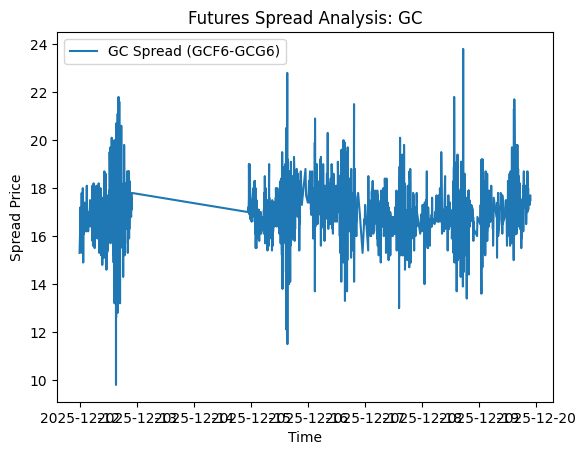

In [39]:
plt.plot(spread_gc.index, spread_gc['close'], label='GC Spread (GCF6-GCG6)')
plt.xlabel('Time')
plt.ylabel('Spread Price')
plt.title('Futures Spread Analysis: GC')
plt.legend()
plt.show()

In [49]:
front_sil = sil_data[sil_data["symbol"] == "SILF6"]
second_sil = sil_data[sil_data["symbol"] == "SILG6"]
spread_sil = (
    second_sil["close"]
    .rename("second")
    .to_frame()
    .join(front_sil["close"].rename("front"), how="inner")
)
spread_sil['close'] = spread_sil['second'] - spread_sil['front']

In [50]:
print(spread_sil['close'].describe())

count    579.000000
mean       0.251278
std        0.048890
min        0.035000
25%        0.230000
50%        0.250000
75%        0.272500
max        0.460000
Name: close, dtype: float64


In [52]:
spread_sil['close'].kurt()

np.float64(3.89103706144195)

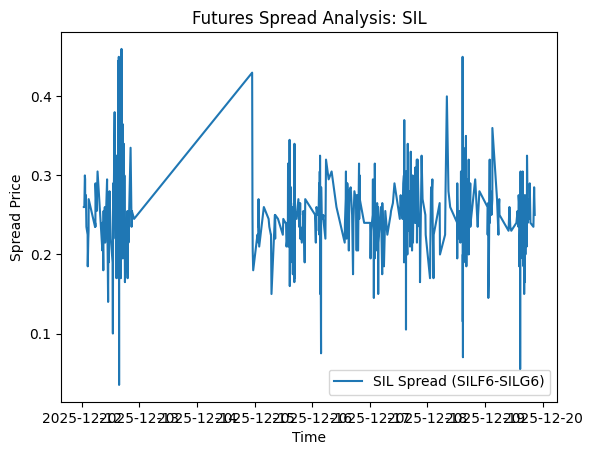

In [51]:
plt.plot(spread_sil.index, spread_sil['close'], label='SIL Spread (SILF6-SILG6)')
plt.xlabel('Time')
plt.ylabel('Spread Price')
plt.title('Futures Spread Analysis: SIL')
plt.legend()
plt.show()

In [54]:
# Pearson Correlation between GC and SIL spreads
merged_spreads = spread_gc['close'].rename('GC_Spread').to_frame().join(
    spread_sil['close'].rename('SIL_Spread'), how='inner'
)
correlation = merged_spreads.corr().loc['GC_Spread', 'SIL_Spread']
print(f'Pearson Correlation between GC and SIL spreads: {correlation}')

Correlation between GC and SIL spreads: -0.17211612155918002


In [62]:
# Spearman correlation between GC and SIL spreads
from scipy.stats import spearmanr
spearman_corr, p_value = spearmanr(merged_spreads['GC_Spread'], merged_spreads['SIL_Spread'])
print(f'Spearman correlation: {spearman_corr}, p-value: {p_value}')

Spearman correlation: -0.1357186912162965, p-value: 0.027460025179570916


In [60]:
# Kendall Tau correlation between GC and SIL spreads
from scipy.stats import kendalltau
tau, p_value = kendalltau(merged_spreads['GC_Spread'], merged_spreads['SIL_Spread'])
print(f'Kendall Tau correlation: {tau}, p-value: {p_value}')

Kendall Tau correlation: -0.09368323296951418, p-value: 0.025836034490976427


In [63]:
# KS test for normality
from scipy.stats import ks_2samp, norm
gc_spread_sample = spread_gc['close'].dropna().sample(n=100, random_state=1)
sil_spread_sample = spread_sil['close'].dropna().sample(n=100, random_state=1)
ks_stat_gc, p_value_gc = ks_2samp(gc_spread_sample, norm.rvs(size=1000, loc=gc_spread_sample.mean(), scale=gc_spread_sample.std()))
ks_stat_sil, p_value_sil = ks_2samp(sil_spread_sample, norm.rvs(size=1000, loc=sil_spread_sample.mean(), scale=sil_spread_sample.std()))
print(f'GC Spread KS statistic: {ks_stat_gc}, p-value: {p_value_gc}')
print(f'SIL Spread KS statistic: {ks_stat_sil}, p-value: {p_value_sil}')

GC Spread KS statistic: 0.076, p-value: 0.6472096107213213
SIL Spread KS statistic: 0.16, p-value: 0.01721871975053444


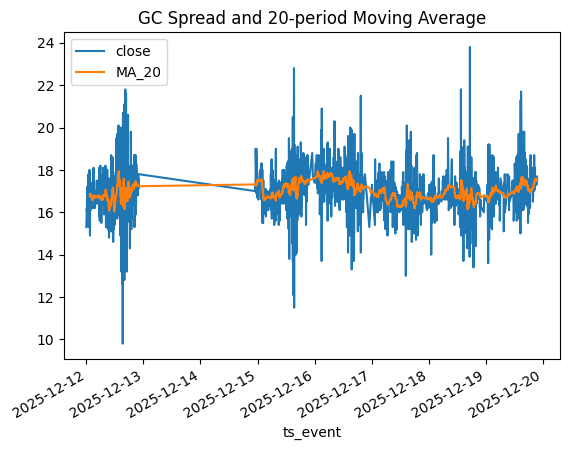

In [55]:
# Difference from moving average
spread_gc['MA_20'] = spread_gc['close'].rolling(window=20).mean()
spread_gc['Diff_MA_20'] = spread_gc['close'] - spread_gc['MA_20']
spread_gc[['close', 'MA_20']].plot(title='GC Spread and 20-period Moving Average')
plt.show()

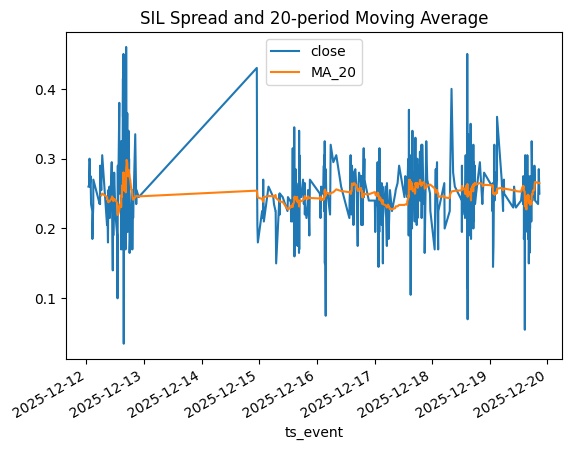

In [56]:
# Difference from moving average
spread_sil['MA_20'] = spread_sil['close'].rolling(window=20).mean()
spread_sil['Diff_MA_20'] = spread_sil['close'] - spread_sil['MA_20']
spread_sil[['close', 'MA_20']].plot(title='SIL Spread and 20-period Moving Average')
plt.show()

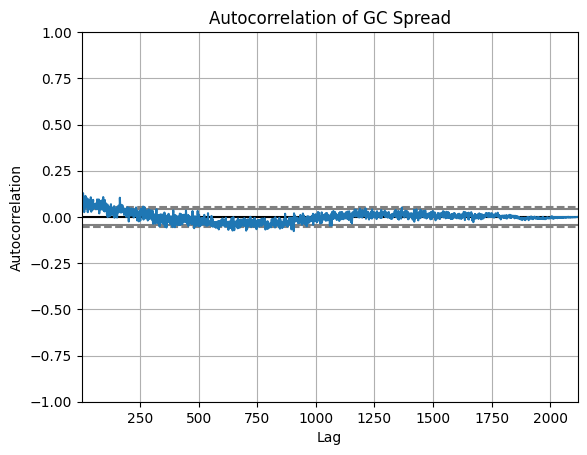

In [57]:
# Autocorrelation analysis
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(spread_gc['close'])
plt.title('Autocorrelation of GC Spread')
plt.show()

Observation: The autocorrelation plot for GC spread shows significant correlation at multiple lags, indicating potential predictability in the spread movements.

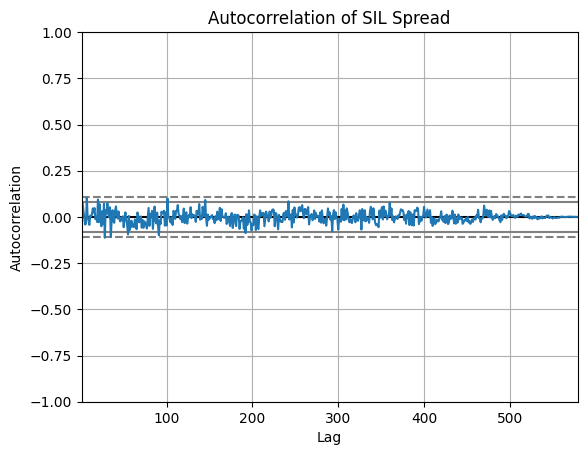

In [58]:
# Autocorrelation analysis
autocorrelation_plot(spread_sil['close'])
plt.title('Autocorrelation of SIL Spread')
plt.show()

Observation: The autocorrelation plot for SIL spread also shows significant correlation at multiple lags, suggesting that the spread has memory and could be predictable over time.

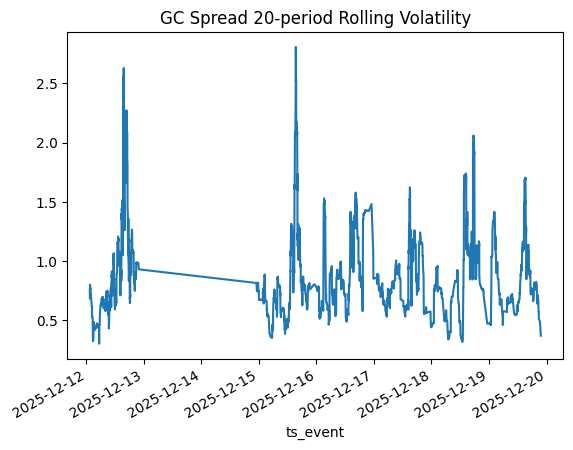

In [64]:
# Volatility analysis using rolling standard deviation
spread_gc['Volatility_20'] = spread_gc['close'].rolling(window=20).std()
spread_gc['Volatility_20'].plot(title='GC Spread 20-period Rolling Volatility')
plt.show()

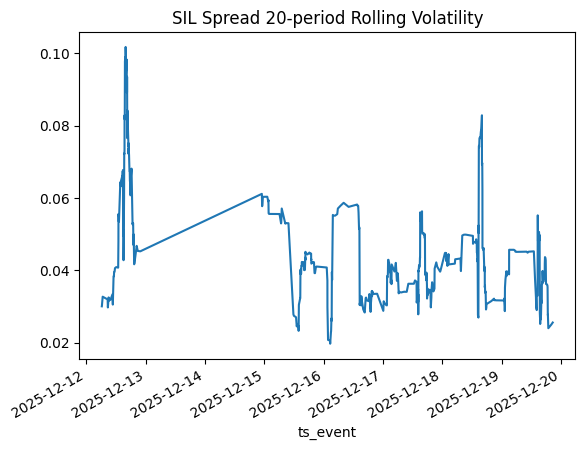

In [65]:
# Volatility analysis using rolling standard deviation
spread_sil['Volatility_20'] = spread_sil['close'].rolling(window=20).std()
spread_sil['Volatility_20'].plot(title='SIL Spread 20-period Rolling Volatility')
plt.show()

In [66]:
# Correlation between volatility of GC and SIL spreads
merged_volatility = spread_gc['Volatility_20'].rename('GC_Volatility').to_frame().join(
    spread_sil['Volatility_20'].rename('SIL_Volatility'), how='inner'
)
volatility_correlation = merged_volatility.corr().loc['GC_Volatility', 'SIL_Volatility']
print(f'Correlation between GC and SIL spread volatilities: {volatility_correlation}')

Correlation between GC and SIL spread volatilities: 0.5751559536209412


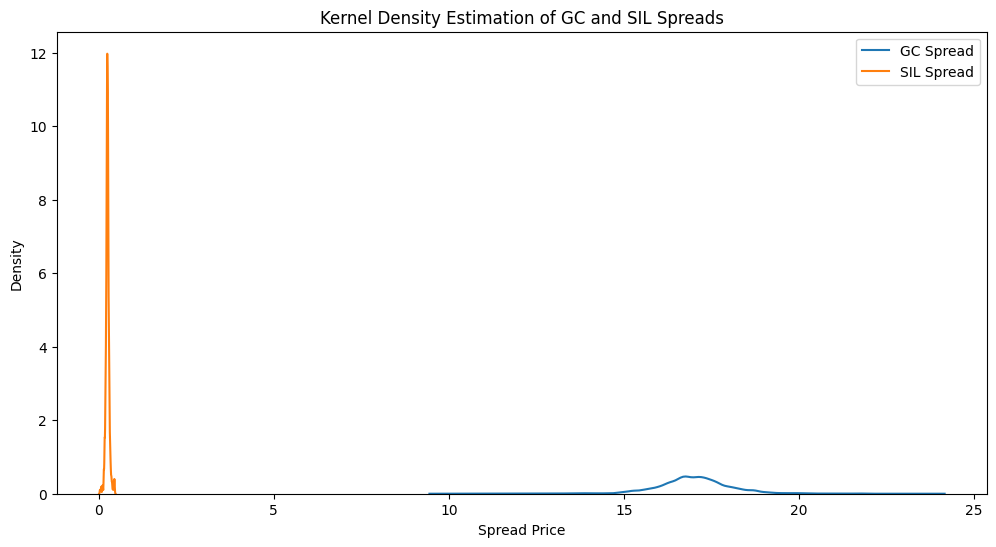

In [68]:
# Tail distribution analysis
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.kdeplot(spread_gc['close'].dropna(), label='GC Spread', bw_adjust=0.5)
sns.kdeplot(spread_sil['close'].dropna(), label='SIL Spread', bw_adjust=0.5)
plt.title('Kernel Density Estimation of GC and SIL Spreads')
plt.xlabel('Spread Price')
plt.ylabel('Density')
plt.legend()
plt.show()

**Tail distribution commentary**
- The KDE plots indicate that both GC and SIL spreads exhibit fat tails, suggesting a higher likelihood of extreme spread values compared to a normal distribution.